In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ee6611; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Settings')

In [3]:
import os,numpy as np,pandas as pd
import pylab as pl,seaborn as sn,tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image as kimg
from tqdm import tqdm
from IPython.core.magic import register_line_magic
import tensorflow_hub as th
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from PIL import ImageFile

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES=True
img_size,img_size2=32,96
classes=['plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck']
manners=['pictogram','contour','sketch']
objects=['flower','bird','butterfly','tree',
         'plane','crane','dog','horse','deer',
         'truck','car','cat','frog','ship']
fpath='../input/art-pictogram/pictogram/'
flist=sorted(os.listdir(fpath))
fw='weights.best.hdf5'
history,model=[],[]
x_train,rx_train,y_train,\
x_test,rx_test,y_test,\
x_valid,rx_valid,y_valid=\
[],[],[],[],[],[],[],[],[]

In [5]:
def img_resize(x):
    global img_size2        
    x=tf.image.resize(x,[img_size2,img_size2])
    return x.numpy()

In [6]:
dhtml('NN Models')

In [7]:
@register_line_magic
def cnn_model(n):
    global history,model,img_size,\
    x_train,y_train,x_test,y_test,x_valid,y_valid
    if n=='1': 
        x_train,y_train=x_train1,y_train1
        x_valid,y_valid=x_valid1,y_valid1
    if n=='2': 
        x_train,y_train=x_train2,y_train2
        x_valid,y_valid=x_valid2,y_valid2
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(tkl.Activation('relu'))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.Activation('relu'))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.GlobalAveragePooling2D())    
    model.add(tkl.Dense(1024,activation='relu'))
    model.add(tkl.Dropout(.5))         
    model.add(tkl.Dense(10))
    model.add(tkl.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                     save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    history=model.fit(x_train,y_train,epochs=100,
                      batch_size=64,verbose=2,
                      validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])

In [8]:
@register_line_magic
def hub_model(n):
    global history,model,img_size2,\
    rx_train,y_train,rx_test,y_test,rx_valid,y_valid
    if n=='1': 
        rx_train,y_train=rx_train1,y_train1
        rx_valid,y_valid=rx_valid1,y_valid1
    if n=='2': 
        rx_train,y_train=rx_train2,y_train2
        rx_valid,y_valid=rx_valid2,y_valid2
    handle_base="mobilenet_v2_050_96"
    mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
    .format(handle_base)
    model=tf.keras.Sequential([
        tf.keras.layers.Input((img_size2,img_size2,3),
                              name='input'),
        th.KerasLayer(mhandle,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(10,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy') 
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                     save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    history=model.fit(rx_train,y_train,epochs=50,
                      batch_size=64,verbose=2,
                      validation_data=(rx_valid,y_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])

In [9]:
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#ee6611',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#ee6611',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [10]:
dhtml('Pictogram Data')

In [11]:
def path_to_tensor(img_path,fpath):
    img=kimg.load_img(fpath+img_path,
                      target_size=(img_size,img_size))
    x=kimg.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
labels1=np.array([int(el[:2]) for el in flist],
                 dtype='int8')-1
labels2=np.array([int(el[3:6]) for el in flist],
                 dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath=fpath))/255
n2=len(labels1[labels1==0])
images=images[:n2]; labels2=labels2[:n2]
cond=np.where([l in classes for l in objects])[0]
cond2=np.where([l in cond for l in labels2])
x=images[cond2]; y=labels2[cond2]
rd={1:2,4:0,6:5,7:7,8:4,9:9,10:1,11:3,12:6,13:8}
y=np.array([rd.get(el,el) for el in y],
            dtype='int8')
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(123).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test1,x_valid1,x_train1=x[:n],x[n:2*n],x[2*n:]
y_test1,y_valid1,y_train1=y[:n],y[n:2*n],y[2*n:]

100%|██████████| 2030/2030 [00:02<00:00, 679.62it/s]


[(1102, 32, 32, 3), dtype('float32'), (1102,), dtype('int8')]
Label:  dog


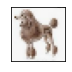

In [12]:
print([x.shape,x.dtype,y.shape,y.dtype])
print('Label: ',classes[y[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x[100]);

In [13]:
%cnn_model 1

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.30313, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.3266 - accuracy: 0.0998 - val_loss: 2.3031 - val_accuracy: 0.1091
Epoch 2/100

Epoch 00002: val_loss improved from 2.30313 to 2.30058, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.3002 - accuracy: 0.1100 - val_loss: 2.3006 - val_accuracy: 0.1091
Epoch 3/100

Epoch 00003: val_loss improved from 2.30058 to 2.29558, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2952 - accuracy: 0.1213 - val_loss: 2.2956 - val_accuracy: 0.1091
Epoch 4/100

Epoch 00004: val_loss improved from 2.29558 to 2.28953, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2879 - accuracy: 0.1270 - val_loss: 2.2895 - val_accuracy: 0.1636
Epoch 5/100

Epoch 00005: val_loss improved from 2.28953 to 2.24601, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2642 - accuracy: 0.1474 - val_loss: 2.2460 - val_accuracy: 0.2273
Epoch 6/100

Epoch 00006: val_loss improved from 2.246

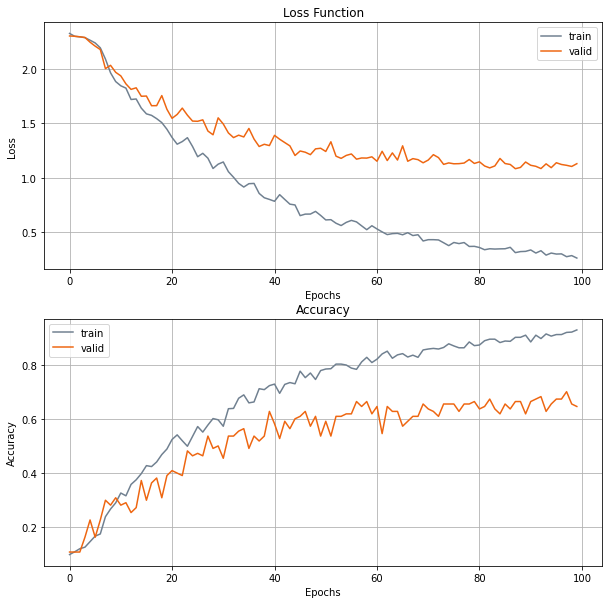

In [14]:
history_plot(history)

In [15]:
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

4/4 [==============================] - 0s 4ms/step - loss: 1.1533 - accuracy: 0.7000


[1.1533340215682983, 0.699999988079071]

[(882, 96, 96, 3), dtype('float32')]
Label:  dog


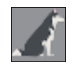

In [16]:
rx_train1,rx_test1,rx_valid1=\
img_resize(x_train1),img_resize(x_test1),img_resize(x_valid1)
print([rx_train1.shape,rx_train1.dtype])
print('Label: ',classes[y_valid1[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(rx_valid1[100]);

In [17]:
%hub_model 1

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.57255, saving model to weights.best.hdf5
14/14 - 2s - loss: 1.3983 - accuracy: 0.5499 - val_loss: 1.5726 - val_accuracy: 0.6364
Epoch 2/50

Epoch 00002: val_loss did not improve from 1.57255
14/14 - 1s - loss: 0.3768 - accuracy: 0.8912 - val_loss: 1.7004 - val_accuracy: 0.6364
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.57255
14/14 - 1s - loss: 0.2498 - accuracy: 0.9240 - val_loss: 2.4901 - val_accuracy: 0.6364
Epoch 4/50

Epoch 00004: val_loss did not improve from 1.57255
14/14 - 1s - loss: 0.2232 - accuracy: 0.9501 - val_loss: 2.2183 - val_accuracy: 0.6636
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.57255
14/14 - 1s - loss: 0.1558 - accuracy: 0.9626 - val_loss: 3.6145 - val_accuracy: 0.6000
Epoch 6/50

Epoch 00006: val_loss did not improve from 1.57255

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
14/14 - 1s - loss: 0.1926 - accuracy: 0.9580 - val_loss: 2.2200 - val_ac

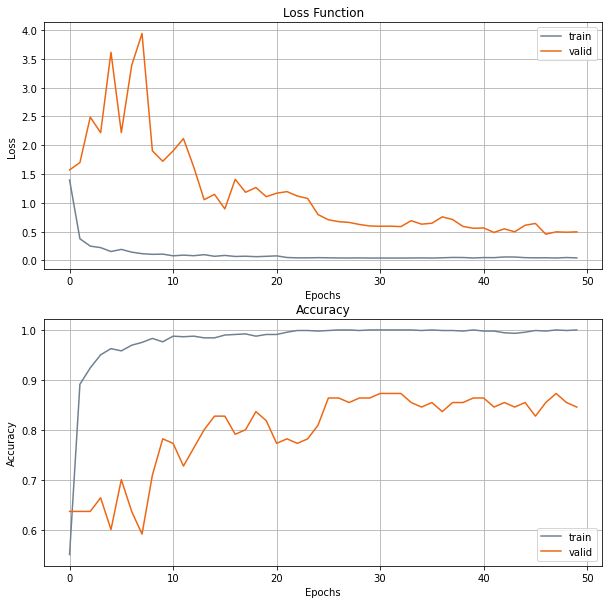

In [18]:
history_plot(history)

In [19]:
model.load_weights(fw)
model.evaluate(rx_test1,y_test1)

4/4 [==============================] - 0s 22ms/step - loss: 1.1477 - accuracy: 0.7909


[1.1476668119430542, 0.7909091114997864]

In [20]:
dhtml('CIFAR Data')

In [21]:
(x,y),(_,_)=cifar10.load_data()
x2=np.array(x,dtype='float32')/255
y2=y.reshape(-1)
N2=len(y2); n2=int(.1*N2)
shuffle_ids2=np.arange(N2)
np.random.RandomState(234).shuffle(shuffle_ids2)
shuffle_ids2=shuffle_ids2[:N]
x2,y2=x2[shuffle_ids2],y2[shuffle_ids2]
x_test2,x_valid2,x_train2=x2[:n],x2[n:2*n],x2[2*n:]
y_test2,y_valid2,y_train2=y2[:n],y2[n:2*n],y2[2*n:]

170500096/170498071 [==============================] - 6s 0us/step


[(1102, 32, 32, 3), dtype('float32'), (1102,), dtype('uint8')]
Label:  truck


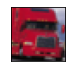

In [22]:
print([x2.shape,x2.dtype,y2.shape,y2.dtype])
print('Label: ',classes[y2[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x2[100]);

In [23]:
%cnn_model 2

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.29624, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.3051 - accuracy: 0.1020 - val_loss: 2.2962 - val_accuracy: 0.1545
Epoch 2/100

Epoch 00002: val_loss improved from 2.29624 to 2.26096, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2747 - accuracy: 0.1451 - val_loss: 2.2610 - val_accuracy: 0.1818
Epoch 3/100

Epoch 00003: val_loss improved from 2.26096 to 2.19570, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2089 - accuracy: 0.1723 - val_loss: 2.1957 - val_accuracy: 0.1818
Epoch 4/100

Epoch 00004: val_loss improved from 2.19570 to 2.11691, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.1419 - accuracy: 0.2041 - val_loss: 2.1169 - val_accuracy: 0.2273
Epoch 5/100

Epoch 00005: val_loss improved from 2.11691 to 2.04053, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.0867 - accuracy: 0.2132 - val_loss: 2.0405 - val_accuracy: 0.2364
Epoch 6/100

Epoch 00006: val_loss improved from 2.040

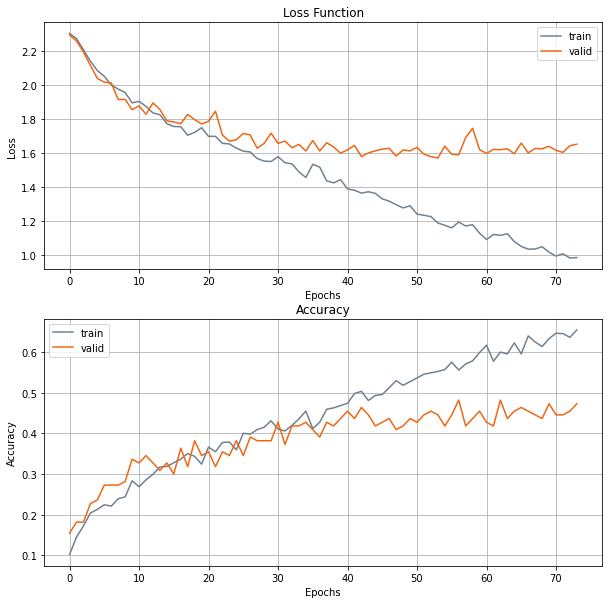

In [24]:
history_plot(history)

In [25]:
model.load_weights(fw)
model.evaluate(x_test2,y_test2)

4/4 [==============================] - 0s 2ms/step - loss: 1.4044 - accuracy: 0.4636


[1.4044201374053955, 0.4636363685131073]

[(882, 32, 32, 3), dtype('float32')]
Label:  plane


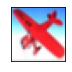

In [26]:
rx_train2,rx_test2,rx_valid2=\
img_resize(x_train2),img_resize(x_test2),img_resize(x_valid2)
print([x_train2.shape,x_train2.dtype])
print('Label: ',classes[y_valid2[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x_valid2[100]);

In [27]:
%hub_model 2

Epoch 1/50

Epoch 00001: val_loss improved from inf to 3.10391, saving model to weights.best.hdf5
14/14 - 2s - loss: 1.8403 - accuracy: 0.4909 - val_loss: 3.1039 - val_accuracy: 0.3273
Epoch 2/50

Epoch 00002: val_loss did not improve from 3.10391
14/14 - 1s - loss: 0.5449 - accuracy: 0.8390 - val_loss: 4.3882 - val_accuracy: 0.4091
Epoch 3/50

Epoch 00003: val_loss did not improve from 3.10391
14/14 - 1s - loss: 0.2648 - accuracy: 0.9274 - val_loss: 5.0431 - val_accuracy: 0.3818
Epoch 4/50

Epoch 00004: val_loss did not improve from 3.10391
14/14 - 1s - loss: 0.1370 - accuracy: 0.9683 - val_loss: 7.8054 - val_accuracy: 0.3273
Epoch 5/50

Epoch 00005: val_loss did not improve from 3.10391
14/14 - 1s - loss: 0.1317 - accuracy: 0.9751 - val_loss: 6.2561 - val_accuracy: 0.4182
Epoch 6/50

Epoch 00006: val_loss improved from 3.10391 to 2.98941, saving model to weights.best.hdf5
14/14 - 1s - loss: 0.1300 - accuracy: 0.9694 - val_loss: 2.9894 - val_accuracy: 0.5545
Epoch 7/50

Epoch 00007: v

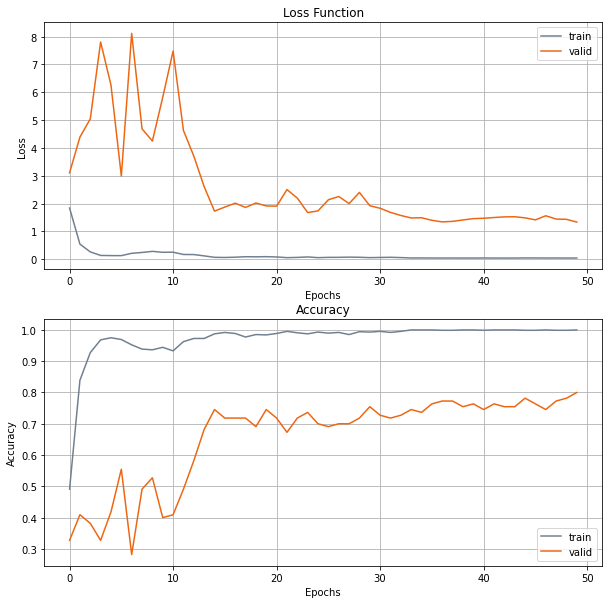

In [28]:
history_plot(history)

In [29]:
model.load_weights(fw)
model.evaluate(rx_test2,y_test2)

4/4 [==============================] - 0s 6ms/step - loss: 1.6658 - accuracy: 0.7727


[1.665824055671692, 0.7727272510528564]

In [30]:
dhtml('Mixed Data')

In [31]:
x_train=np.vstack([x_train1,x_train2])
x_test=np.vstack([x_test1,x_test2])
x_valid=np.vstack([x_valid1,x_valid2])
y_train=np.hstack([y_train1,y_train2])
y_test=np.hstack([y_test1,y_test2])
y_valid=np.hstack([y_valid1,y_valid2])
for [x,y] in [[x_train,y_train],
              [x_test,y_test],
              [x_valid,y_valid]]:
    N=len(y); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x,y=x[shuffle_ids],y[shuffle_ids]
    print([x.shape,x.dtype,y.shape,y.dtype])

[(1764, 32, 32, 3), dtype('float32'), (1764,), dtype('int16')]
[(220, 32, 32, 3), dtype('float32'), (220,), dtype('int16')]
[(220, 32, 32, 3), dtype('float32'), (220,), dtype('int16')]


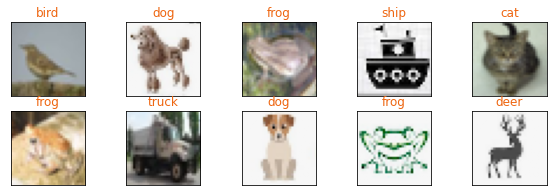

In [32]:
fig=pl.figure(figsize=(10,3))
randch=np.random.choice(x_test.shape[0],
                        size=10,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,5,i+1,
                       xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    true_idx=y_test[idx]
    ax.set_title(classes[true_idx],color="#ee6611")

In [33]:
%cnn_model 0

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.28627, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.3021 - accuracy: 0.1117 - val_loss: 2.2863 - val_accuracy: 0.1182
Epoch 2/100

Epoch 00002: val_loss improved from 2.28627 to 2.18606, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.2577 - accuracy: 0.1604 - val_loss: 2.1861 - val_accuracy: 0.1909
Epoch 3/100

Epoch 00003: val_loss did not improve from 2.18606
28/28 - 0s - loss: 2.2446 - accuracy: 0.1434 - val_loss: 2.2012 - val_accuracy: 0.1773
Epoch 4/100

Epoch 00004: val_loss improved from 2.18606 to 2.16641, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.1830 - accuracy: 0.1939 - val_loss: 2.1664 - val_accuracy: 0.1864
Epoch 5/100

Epoch 00005: val_loss improved from 2.16641 to 1.99085, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.1008 - accuracy: 0.2217 - val_loss: 1.9909 - val_accuracy: 0.2455
Epoch 6/100

Epoch 00006: val_loss improved from 1.99085 to 1.97631, saving model to weights.

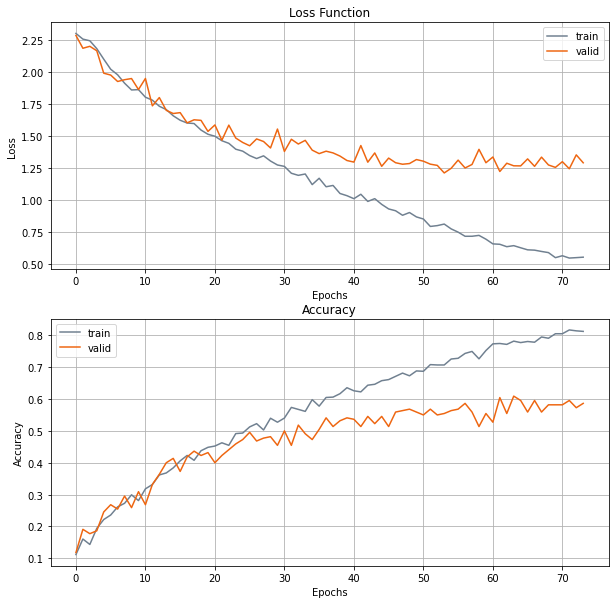

In [34]:
history_plot(history)

In [35]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.2100 - accuracy: 0.5727


[1.21004056930542, 0.5727272629737854]

In [36]:
rx_train=np.vstack([rx_train1,rx_train2])
rx_test=np.vstack([rx_test1,rx_test2])
rx_valid=np.vstack([rx_valid1,rx_valid2])
y_train=np.hstack([y_train1,y_train2])
y_test=np.hstack([y_test1,y_test2])
y_valid=np.hstack([y_valid1,y_valid2])
for [x,y] in [[rx_train,y_train],
              [rx_test,y_test],
              [rx_valid,y_valid]]:
    N=len(y); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x,y=x[shuffle_ids],y[shuffle_ids]
    print([x.shape,x.dtype,y.shape,y.dtype])

[(1764, 96, 96, 3), dtype('float32'), (1764,), dtype('int16')]
[(220, 96, 96, 3), dtype('float32'), (220,), dtype('int16')]
[(220, 96, 96, 3), dtype('float32'), (220,), dtype('int16')]


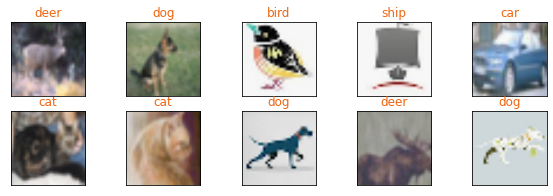

In [37]:
fig=pl.figure(figsize=(10,3))
randch=np.random.choice(rx_test.shape[0],
                        size=10,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,5,i+1,
                       xticks=[],yticks=[])
    ax.imshow(rx_test[idx])
    true_idx=y_test[idx]
    ax.set_title(classes[true_idx],color="#ee6611")

In [38]:
%hub_model 0

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.76283, saving model to weights.best.hdf5
28/28 - 3s - loss: 1.3898 - accuracy: 0.5805 - val_loss: 1.7628 - val_accuracy: 0.5773
Epoch 2/50

Epoch 00002: val_loss improved from 1.76283 to 1.43313, saving model to weights.best.hdf5
28/28 - 2s - loss: 0.6118 - accuracy: 0.8169 - val_loss: 1.4331 - val_accuracy: 0.6500
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.43313
28/28 - 1s - loss: 0.3569 - accuracy: 0.9031 - val_loss: 2.1058 - val_accuracy: 0.6182
Epoch 4/50

Epoch 00004: val_loss did not improve from 1.43313
28/28 - 1s - loss: 0.3157 - accuracy: 0.9212 - val_loss: 2.6754 - val_accuracy: 0.5727
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.43313
28/28 - 1s - loss: 0.2948 - accuracy: 0.9212 - val_loss: 1.8731 - val_accuracy: 0.6727
Epoch 6/50

Epoch 00006: val_loss improved from 1.43313 to 1.34584, saving model to weights.best.hdf5
28/28 - 2s - loss: 0.2627 - accuracy: 0.9325 - val_loss: 1.3458 - val_accu

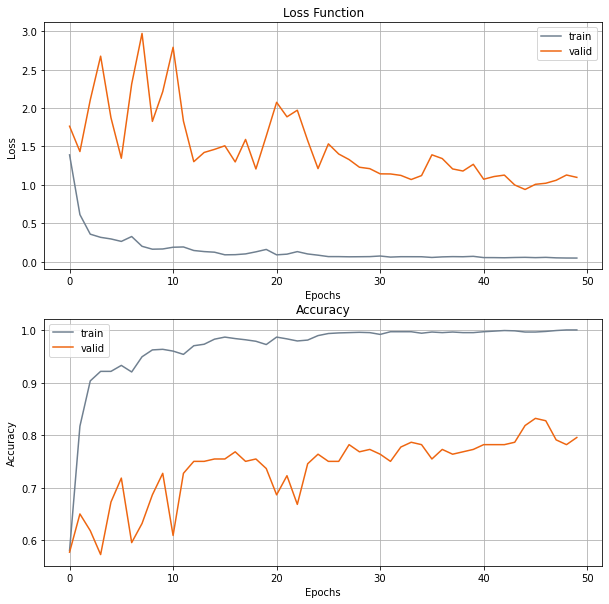

In [39]:
history_plot(history)

In [40]:
model.load_weights(fw)
model.evaluate(rx_test,y_test)

7/7 [==============================] - 0s 7ms/step - loss: 0.6668 - accuracy: 0.8591


[0.6668282747268677, 0.8590909242630005]